In [1]:
import os
import torch
import numpy as np
from code_deepQueueNet.attention import SelfAttention
from code_deepQueueNet.model import DeepQueueNet
import torch.nn as nn
import numpy as np
from code_deepQueueNet.config import BaseConfig, modelConfig

In [2]:
device = torch.cuda.set_device(0)
device_id = 0
#state_path = "/net/kihara/scratch/zhang038/CS536_project/saved_models_l2/best_epoch_5.ckpt"
state_path = '/net/kihara/scratch/zhang038/CS536_project/saved_models/best_epoch_100'
base_config = BaseConfig()
model_config = modelConfig()
model = DeepQueueNet(config=BaseConfig, device=device)
model.to(device)
model.eval()
model.load_state_dict(torch.load(state_path)['state_dict'])


<All keys matched successfully>

In [3]:
import h5py
def load_sample(task, file):
    with h5py.File(file, 'r') as hdf:
        x = hdf['x'][:]
        y = hdf['y'][:]
    return x, y


In [36]:
x1,y1=load_sample('test1', './data/4-port switch/FIFO/_hdf/test1.h5')
x2,y2=load_sample('test2', './data/4-port switch/FIFO/_hdf/test2.h5')
#x,y=load_sample('train', './data/4-port switch/FIFO/_hdf/train.h5')

In [5]:
x,y  =load_sample('train', model_config.train_sample)
x1,y1=load_sample('test1', model_config.test1_sample)
x2,y2=load_sample('test2', model_config.test2_sample)

In [7]:
y_pred = []
batch_size = 1024
x = torch.from_numpy(x).float()
chuncked_x = torch.split(x, batch_size,0)
for sample in chuncked_x:
    sample = sample.to(device)
    y_pred.extend(model(sample).detach().cpu().numpy())

In [8]:
y_pred = np.array(y_pred)
np.save("y_pred.npy",y_pred)

In [18]:
# x = torch.from_numpy(x).float().to(device)
# y_pred = model(x)
# y_pred = y_pred.detach().cpu().numpy()

# print(y_pred)


114247

In [5]:
y1_pred = []
batch_size = 1024
x1 = torch.from_numpy(x1).float()
chuncked_x1 = torch.split(x1, batch_size,0)
for sample in chuncked_x1:
    sample = sample.to(device)
    y1_pred.extend(model(sample).detach().cpu().numpy())

In [10]:
y1_pred = np.array(y1_pred)
np.save("y1_pred.npy",y1_pred)

In [6]:
y2_pred = []
x2 = torch.from_numpy(x2).float()
chuncked_x2 = torch.split(x2, batch_size,0)
for sample in chuncked_x2:
    sample = sample.to(device)
    y2_pred.extend(model(sample).detach().cpu().numpy())
y2_pred = np.array(y2_pred)
np.save("y2_pred.npy",y2_pred)

In [7]:
import pandas as pd
def load_scaler(folder):
    x_MIN=pd.read_csv(folder+'/x_MIN.csv', names=['key','value']).set_index('key')['value']
    x_MAX=pd.read_csv(folder+'/x_MAX.csv', names=['key','value']).set_index('key')['value']
    y_MIN=pd.read_csv(folder+'/y_MIN.csv', names=['key','value']).set_index('key')['value']
    y_MAX=pd.read_csv(folder+'/y_MAX.csv', names=['key','value']).set_index('key')['value']
    fet_cols=list(x_MIN.keys())
    target=list(y_MIN.keys())
    return x_MIN, x_MAX, y_MIN, y_MAX, fet_cols, target

In [8]:
folder = './data/{}/_scaler'.format(base_config.modelname)
folder = './data/{}/_scaler'.format(base_config.modelname)
x_MIN, x_MAX, y_MIN, y_MAX, fet_cols, target = load_scaler(folder)
y_MAX=y_MAX['time_in_sys']
y_MIN=y_MIN['time_in_sys']

In [9]:
y_RANGE=y_MAX-y_MIN
print(y_RANGE)
print(y_MIN)

0.018250212998
2.5177002000000002e-05


In [11]:
y1_pred = np.array(y1_pred)
y2_pred = np.array(y2_pred)

In [13]:
#y =y[:,0]*y_RANGE+y_MIN 
y1=y1*y_RANGE+y_MIN 
y2=y2*y_RANGE+y_MIN 
#y_pred =y_pred*y_RANGE+y_MIN 
y1_pred=y1_pred*y_RANGE+y_MIN 
y2_pred=y2_pred*y_RANGE+y_MIN 

In [14]:
#y_pred = y_pred.reshape(-1)
y1_pred = y1_pred.reshape(-1)
y2_pred = y2_pred.reshape(-1)

In [35]:
y1

array([2.59865284e-05, 2.58171616e-05, 2.59362348e-05, ...,
       2.59211919e-05, 2.58171616e-05, 2.60828903e-05])

In [31]:
# coll={'train': [131, y*1e3, y_pred*1e3], 
# 'test: endogeny': [132, y1*1e3, y1_pred*1e3],
# 'test: exogenesis': [133, y2*1e3, y2_pred*1e3]}
coll={
'test: endogeny': [132, y1, y1_pred],
'test: exogenesis': [133, y2, y2_pred]}


In [29]:
print(coll['test: endogeny'][1][4],coll['test: endogeny'][2][4])


2.5817161599554392 5.419565


In [22]:
print(coll['test1'][2])

KeyError: 'test1'

Text(0.5, 0.98, 'regression plot\n\n\n\n\n')

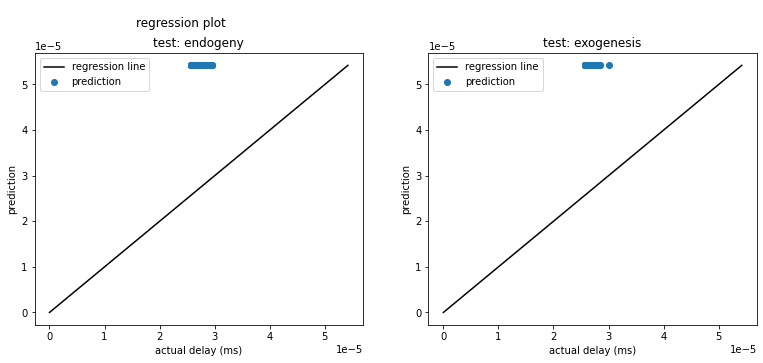

In [32]:
import matplotlib.pyplot as plt
import scipy.stats as measures
plt.figure(figsize=(20,5))
for k, v in coll.items():
    Max =max(max(v[1]),  max(v[2]))
    plt.subplot(v[0])
    plt.scatter(v[1], v[2],label='prediction')
    plt.plot([0,Max],[0,Max], color='k',label='regression line')
    plt.legend()
    plt.xlabel('actual delay (ms)')
    plt.ylabel('prediction')
    plt.title('\n\n{}'.format(k))
plt.suptitle('regression plot\n\n\n\n\n')

In [54]:
def distrib():
    Result=pd.DataFrame(y, columns=['delay'])
    Result['prediction']=y_pred
    Result['error']=y_pred-y
    Result['priority']=0
    Result.to_csv('./data/{}/_error/train.csv'.format(base_config.modelname), index=False)
    Result1=pd.DataFrame(y1, columns=['delay'])
    Result1['prediction']=y1_pred
    Result2=pd.DataFrame(y2, columns=['delay'])
    Result2['prediction']=y2_pred
    return Result,Result1,Result2
    

In [55]:
Result,Result1,Result2 =  distrib()

In [56]:
Result.to_csv("tzzs_data.csv")

In [57]:
print(Result)

          delay  prediction     error  priority
0      0.000052    0.000074  0.000022         0
1      0.000843    0.000074 -0.000770         0
2      0.000025    0.000074  0.000049         0
3      0.000025    0.000073  0.000048         0
4      0.001524    0.000074 -0.001451         0
...         ...         ...       ...       ...
75875  0.000568    0.000071 -0.000496         0
75876  0.001482    0.000071 -0.001411         0
75877  0.000569    0.000073 -0.000496         0
75878  0.000619    0.000072 -0.000547         0
75879  0.000775    0.000073 -0.000702         0

[75880 rows x 4 columns]


In [64]:
import scipy.stats as measures
from scipy import stats
df = Result2 *1e3
disp = 'train'

Text(0.5, 0.98, 'delay analysis: train')

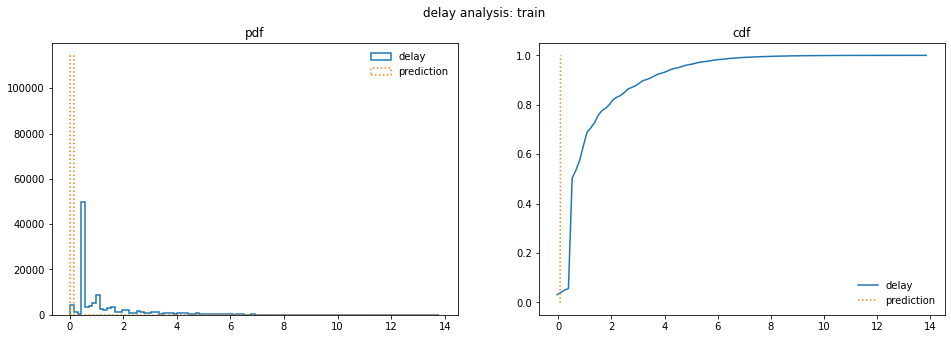

In [98]:
plt.figure(figsize=(16,5))
plt.subplot(121)
bins=np.histogram(np.hstack((df['delay'].values, df['prediction'].values)), bins=100)[1]  
plt.hist(df['delay'].values, bins, density=False,  histtype='step', label='delay', lw=1.5);
plt.hist(df['prediction'].values, bins, density=False,  histtype='step', label='prediction',linestyle=':',lw=1.5);
plt.title('pdf')
plt.legend(frameon=False, loc="best")

plt.subplot(122)
_res=stats.relfreq(df['delay'].values, numbins=100)
res_=stats.relfreq(df['prediction'].values, numbins=100)
_x=_res.lowerlimit + np.linspace(0, _res.binsize*_res.frequency.size, _res.frequency.size)
_y=np.cumsum(_res.frequency)
x_=res_.lowerlimit + np.linspace(0, res_.binsize*res_.frequency.size, res_.frequency.size)
y_=np.cumsum(res_.frequency)
plt.plot(_x, _y,label='delay',lw=1.5)
plt.plot(x_, y_,  linestyle=':', label='prediction',lw=1.5)
plt.title('cdf');
plt.legend(frameon=False, loc="best")
plt.suptitle('delay analysis: {}'.format(disp))

In [ ]:
# pdf_cdf(Result*1e3, disp='train') 
# pdf_cdf(Result1*1e3, disp='test_endogeny')   
# pdf_cdf(Result2*1e3, disp='test_exogenesis')

No handles with labels found to put in legend.


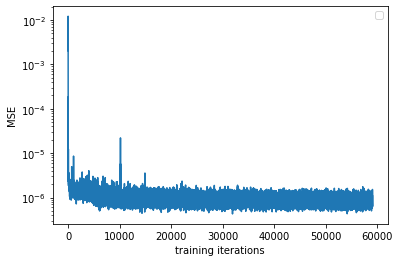

In [97]:
#########Draw learning curve
import matplotlib.pyplot as plt
with open("logs/train_same_batch.log") as file:
    lines = file.readlines()
loss = []
iterations = []
for i in range(len(lines)):
    iterations.append(i+1)
    loss.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations, loss )
plt.xlabel("training iterations")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()

No handles with labels found to put in legend.


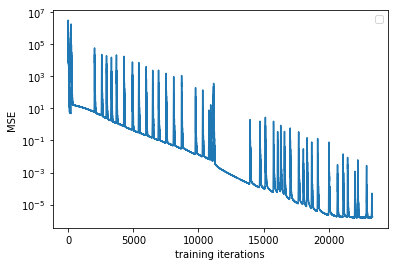

In [99]:
import matplotlib.pyplot as plt
with open("logs/train_nolstm.log") as file:
    lines = file.readlines()
loss = []
iterations = []
for i in range(len(lines)):
    iterations.append(i+1)
    loss.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations, loss )
plt.xlabel("training iterations")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()